In [2]:
import numpy as np
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import time

# Example: A chaotic pendulum

In [3]:
chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>
      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
data = mujoco.MjData(model)
# renderer = mujoco.Renderer(model, 480, 640)
# mujoco.mj_forward(model, data)
# renderer.update_scene(data, camera="fixed")
# media.show_image(renderer.render())

주의! renderer는 한번만 정의해야함
혹은 `del renderer`로 삭제해주면 됨

In [4]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
renderer = mujoco.Renderer(model, 240, 320)


# set initial state
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 10


# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
for i in range(n_frames):
  while data.time * framerate < i:
    tic = time.time()
    mujoco.mj_step(model, data)
    sim_time += time.time() - tic
    n_steps += 1
  tic = time.time()
  renderer.update_scene(data, "fixed")
  frame = renderer.render()
  render_time += time.time() - tic
  frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

simulation:  1.52 μs/step  (655752Hz)
rendering:    637 μs/frame ( 1569Hz)




# chaos

C:\Users\sonen\AppData\Local\Temp\ipykernel_11884\567113803.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angle[i] = data.joint('root').qpos


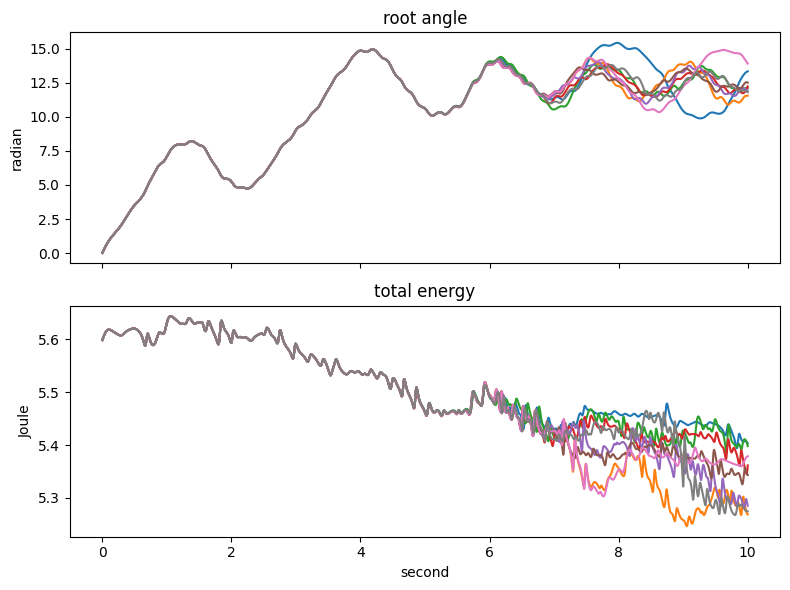

In [5]:
PERTURBATION = 1e-7
SIM_DURATION = 10 # seconds
NUM_REPEATS = 8

# preallocate
n_steps = int(SIM_DURATION / model.opt.timestep)
sim_time = np.zeros(n_steps)
angle = np.zeros(n_steps)
energy = np.zeros(n_steps)

# prepare plotting axes
_, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# simulate NUM_REPEATS times with slightly different initial conditions
for _ in range(NUM_REPEATS):
  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 10 # root joint velocity
  # perturb initial velocities
  data.qvel[:] += PERTURBATION * np.random.randn(model.nv)

  # simulate
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    angle[i] = data.joint('root').qpos
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax[0].plot(sim_time, angle)
  ax[1].plot(sim_time, energy)

# finalize plot
ax[0].set_title('root angle')
ax[0].set_ylabel('radian')
ax[1].set_title('total energy')
ax[1].set_ylabel('Joule')
ax[1].set_xlabel('second')
plt.tight_layout()

# Timestep and accuracy

1000 steps at dt = 10ms
3162 steps at dt = 3.2ms
10000 steps at dt =  1ms
31622 steps at dt = 0.32ms
100000 steps at dt = 0.1ms


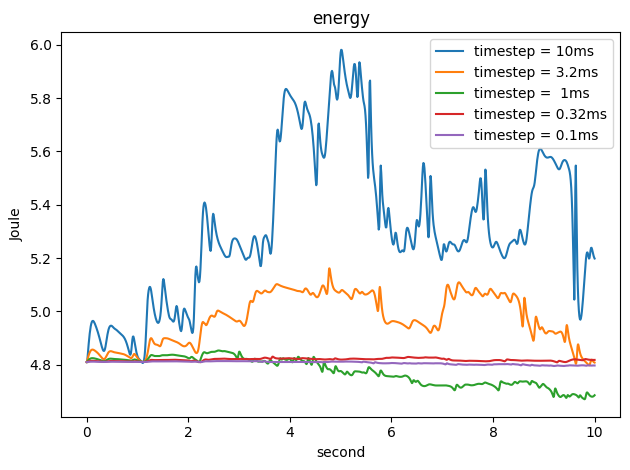

In [6]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -4, 5))

# prepare plotting axes
_, ax = plt.subplots(1, 1)

for dt in TIMESTEPS:
   # set timestep, print
  model.opt.timestep = dt

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps)

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 9 # root joint velocity

  # simulate
  print('{} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True);
plt.tight_layout()

# Timestep and divergence

simulating 1000 steps at dt = 10ms
stopped due to divergence (mjWARN_BADQACC) at timestep 385.

simulating 825 steps at dt = 12ms
stopped due to divergence (mjWARN_BADQACC) at timestep 322.

simulating 681 steps at dt = 15ms
stopped due to divergence (mjWARN_BADQACC) at timestep 166.

simulating 562 steps at dt = 18ms
stopped due to divergence (mjWARN_BADQACC) at timestep 105.

simulating 464 steps at dt = 22ms
stopped due to divergence (mjWARN_BADQACC) at timestep 84.

simulating 383 steps at dt = 26ms
stopped due to divergence (mjWARN_BADQACC) at timestep 61.

simulating 316 steps at dt = 32ms
stopped due to divergence (mjWARN_BADQACC) at timestep 45.



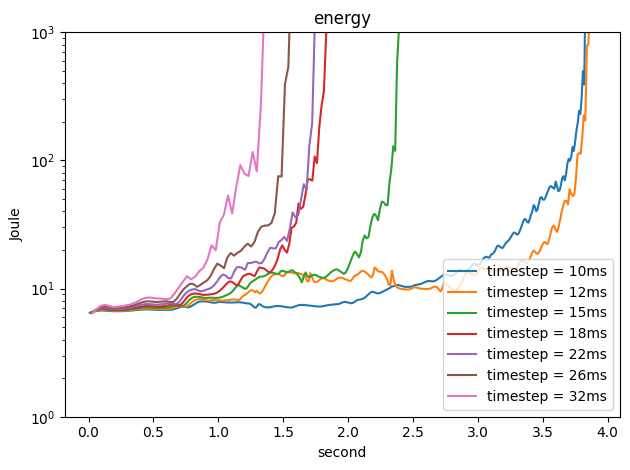

In [9]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -1.5, 7))

# get plotting axes
ax = plt.gca()

for dt in TIMESTEPS:
  # set timestep
  model.opt.timestep = dt

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps) * np.nan
  speed = np.zeros(n_steps) * np.nan

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 11 # set root joint velocity

  # simulate
  print('simulating {} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    if data.warning.number.any():
      warning_index = np.nonzero(data.warning.number)[0][0]
      warning = mujoco.mjtWarning(warning_index).name
      print(f'stopped due to divergence ({warning}) at timestep {i}.\n')
      break
    sim_time[i] = data.time
    energy[i] = sum(abs(data.energy))
    speed[i] = np.linalg.norm(data.qvel)

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))
  ax.set_yscale('log')


# finalize plot
ax.set_ybound(1, 1e3)
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()
